In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Đọc dữ liệu từ file Excel
df = pd.read_excel('/kaggle/input/mbbdataset/Simplize_MBB_PriceHistory_20250511.xlsx')

# Đổi tên cột cho tiện xử lý (nếu là tiếng Việt)
df = df.rename(columns={
    'NGÀY': 'Date',
    'GIÁ MỞ CỬA': 'Open',
    'GIÁ CAO NHẤT': 'High',
    'GIÁ THẤP NHẤT': 'Low',
    'GIÁ ĐÓNG CỬA': 'Close',
    'KHỐI LƯỢNG': 'Volume'
})

# Chuyển Date sang dạng datetime và sắp xếp
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Chọn các cột dùng để huấn luyện
data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# SMA và EMA
df['SMA_14'] = ta.trend.sma_indicator(df['Close'], window=14)
df['EMA_14'] = ta.trend.ema_indicator(df['Close'], window=14)

# RSI
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)

# Thay đổi giá theo phần trăm so với ngày trước đó
df['Price_Change'] = df['Close'].pct_change()

# Độ biến động (độ lệch chuẩn trong 14 ngày)
df['Volatility'] = df['Close'].rolling(window=14).std()

df.dropna(inplace=True)

# Hiển thị vài dòng đầu
data.head()

2025-05-11 13:30:32.517801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746970232.795463      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746970232.867284      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=44abf78a116c5186fa1054cca98e2f1ffb21e49435334ebb0f7cafeeafe02e52
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


,Open,High,Low,Close,Volume
Date,,,,,
2021-05-07,13942.500442,14120.679361,13897.955712,14076.134632,24832400
2021-05-10,14076.134632,14900.212134,14053.862267,14788.850309,36719900
2021-05-11,14788.850309,14877.939769,14566.126660,14566.126660,25385100
2021-05-12,14499.309565,14788.850309,14454.764835,14788.850309,21190000
2021-05-13,14610.671390,15056.118688,14610.671390,14677.488485,26896800


In [2]:
# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Tạo dữ liệu chuỗi thời gian
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, df.columns.get_loc('Close')])  # vị trí của cột Close
    return np.array(X), np.array(y)

# Sử dụng 60 ngày để dự đoán ngày tiếp theo
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Kiểm tra hình dạng đầu vào
print("X shape:", X.shape)  # (samples, timesteps, features)
print("y shape:", y.shape)

X shape: (940, 60, 5)
y shape: (940,)


In [3]:
# 80% dữ liệu dùng để train, còn lại để test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2025-05-11 13:31:50.463327: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0782 - val_loss: 0.0066
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0041 - val_loss: 0.0056
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/ste

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


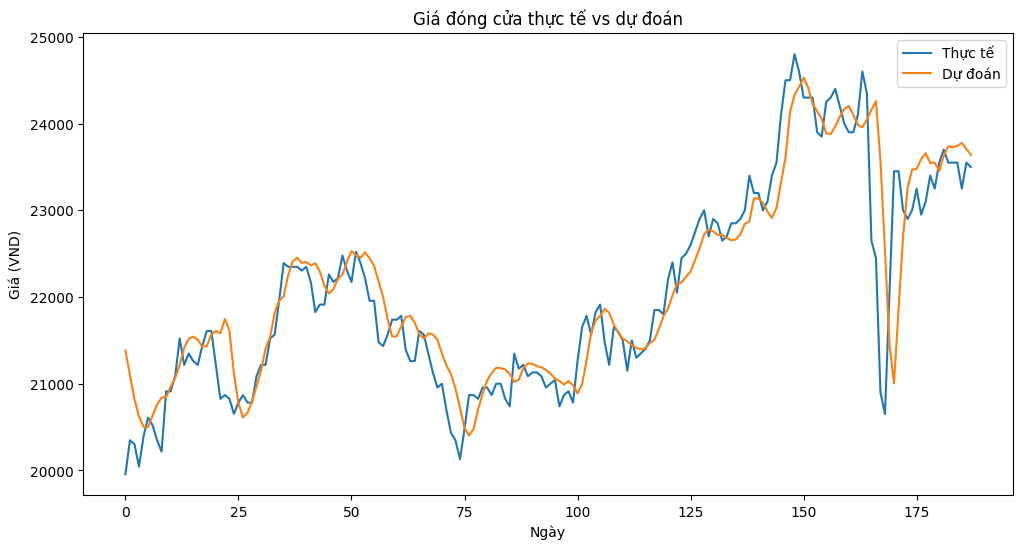

In [6]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chỉ scale lại giá đóng cửa (cột thứ 4)
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]

# Scale ngược lại
y_test_inv = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = close_scaler.inverse_transform(y_pred)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Thực tế')
plt.plot(y_pred_inv, label='Dự đoán')
plt.legend()
plt.title('Giá đóng cửa thực tế vs dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá (VND)')
plt.show()

In [7]:
# Sử dụng đúng biến và đảm bảo kích thước đầu vào khớp với mô hình
last_sequence = scaled_data[-sequence_length:]
input_seq = last_sequence.reshape(1, sequence_length, X.shape[2])

In [8]:
future_predictions = []
num_days = 756  # ~3 năm (252 ngày/năm)

for _ in range(num_days):
    pred = model.predict(input_seq)[0][0]
    future_predictions.append(pred)

    # Tạo chuỗi mới bằng cách dịch dữ liệu và thêm giá trị dự đoán
    next_input = np.append(input_seq[0, 1:, :], [[0, 0, 0, pred, 0]], axis=0)
    input_seq = next_input.reshape(1, sequence_length, data.shape[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [9]:
# Biến đổi giá Close từ [0, 1] về giá thực tế
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
predicted_close = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [11]:
import pandas as pd

# Tạo DataFrame kết quả
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': predicted_close.flatten()
})

# Lưu ra file Excel
forecast_df.to_excel('/kaggle/working/mbb_3_year_forecast.xlsx', index=False)

print("✅ File dự đoán đã được lưu tại: /kaggle/working/mbb_3_year_forecast.xlsx")

✅ File dự đoán đã được lưu tại: /kaggle/working/mbb_3_year_forecast.xlsx
